In [1]:
import sys
sys.path.append('/datasets/home/79/279/cs253wec/warp-ctc/lib')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import time
import copy
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lrs

import torchvision.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from IIIT5K import IIIT5K
from warpctc_pytorch import CTCLoss

In [2]:
vgg16 = models.vgg16(pretrained=True)

In [3]:
vocab=['-']+[chr(ord('a')+i) for i in range(26)]+[chr(ord('A')+i) for i in range(26)]+[chr(ord('0')+i) for i in range(10)]
chrToindex={}
indexTochr={}
cnt=0
for c in vocab:
    chrToindex[c]=cnt
    indexTochr[cnt]=c
    cnt+=1
vocab_size=cnt # uppercase and lowercase English characters and digits(26+26+10=62)
batch_size=1
sequence_len=28
RNN_input_dim=7168
RNN_hidden_dim=256
RNN_layer=2
RNN_type='LSTM'
RNN_dropout=0
use_VGG_extractor=False
learning_rate=1e-4

In [4]:
num_train=1
train_indices=range(num_train)
num_test=3000

mytransform = T.Compose(
    [
        T.Scale((224,224)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
IIIT5K_train = IIIT5K("IIIT5K-Word_V3.0", mytransform, train=True)
loader_train = DataLoader(dataset = IIIT5K_train,batch_size = batch_size, num_workers=2, 
                          sampler=SubsetRandomSampler(train_indices))

IIIT5K_test = IIIT5K("IIIT5K-Word_V3.0", mytransform, train=False)
loader_test = DataLoader(dataset = IIIT5K_test,batch_size = 1, num_workers=1, shuffle=True)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


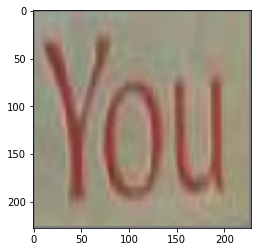

You


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(loader_train)
images, labels = dataiter.next()

# print(images)
# print(labels)

imshow(utils.make_grid(images))
print(' '.join('%s' % labels[j] for j in range(batch_size)))

In [6]:
print('CUDA available :',torch.cuda.is_available())
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor # the GPU datatype

dtype=gpu_dtype
print(dtype)

# From torchvision/vgg.py
def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
#             nn.init.xavier_normal(m.weight, gain=1)
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
#             nn.init.xavier_normal(m.weight, gain=1)
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
            
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

CUDA available : True
<class 'torch.cuda.FloatTensor'>


In [7]:
class CNN_block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(CNN_block, self).__init__()
        self.conv_1=nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_2=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_3=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.batchnorm1=nn.BatchNorm2d(num_features=out_channel)
        self.batchnorm2=nn.BatchNorm2d(num_features=out_channel)
        self.batchnorm3=nn.BatchNorm2d(num_features=out_channel)
        self.relu=nn.ReLU(True)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
    def forward(self, x):
        x=self.relu(self.batchnorm1(self.conv_1(x)))
        x=self.relu(self.batchnorm2(self.conv_2(x)))
        x=self.relu(self.batchnorm3(self.conv_3(x)))
        x=self.maxpool(x)
        return x
    
class ToRNN(nn.Module):
    def forward(self, x):
        x=x.permute(3,0,1,2)
        W,N,C,H= x.size()
        x.contiguous()
        return x.view(W,N,-1)
    
class BiDireRNN(nn.Module):
    def __init__(self):
        super(BiDireRNN, self).__init__()
        self.hidden_dim = RNN_hidden_dim
        self.num_layers=RNN_layer
        self.sql=sequence_len
        self.bsize=batch_size
        self.dropout=RNN_dropout
        self.rnn_type=RNN_type
        self.rnn = self.rnn_layer()
        self.hidden=None
        self.init_hidden(batch_size)
        
    def rnn_layer(self):
        if self.rnn_type=='RNN':
            return nn.RNN(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='LSTM':
            return nn.LSTM(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='GRU':
            return nn.GRU(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        else:
            raise AssertionError('unknown RNN type:',self.rnn_type)
    
    def init_hidden(self,bsize):
        if self.rnn_type=='LSTM':
            self.hidden=(Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype)),
                    Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype)))
        else:
            self.hidden=Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype))
        
    
    def forward(self, x):
        rnn_out, self.hidden = self.rnn(x, self.hidden)
        return rnn_out
        

class Model(nn.Module):
    def __init__(self,use_VGG_extractor=False):
        super(Model, self).__init__()
        if use_VGG_extractor:
            self.feature_extractor=nn.Sequential(*([vgg16.features[i] for i in range(31)]))
            for param in self.feature_extractor.parameters():
                param.requires_grad=False
                
        else:
            self.feature_extractor=nn.Sequential(*([CNN_block(3,64),CNN_block(64,128),CNN_block(128,256)]))
        self.toRNN=ToRNN()
        self.RNN=BiDireRNN()
        self.toTraget=nn.Linear(RNN_hidden_dim*2, vocab_size)
        self.softmax=nn.Softmax(dim=2)

    def forward(self, x):
        feature=self.feature_extractor(x)
        RNN_input=self.toRNN(feature)
        RNN_out=self.RNN(RNN_input)
        tag_scores = self.toTraget(RNN_out)
        prob=self.softmax(tag_scores)
        return prob

In [8]:
my_model=Model(use_VGG_extractor=use_VGG_extractor).type(dtype)
print(my_model)
for param in my_model.named_parameters():
    print(param[0],type(param[1].data),param[1].size(),param[1].requires_grad)

loss_function = CTCLoss().type(dtype)
# opt_parameters=my_model.parameters() if use_VGG_extractor==False else [my_model.RNN.parameters(),my_model.toTraget.parameters()]
# print(opt_parameters)
# optimizer = optim.Adam(opt_parameters, lr=4e-3)

if use_VGG_extractor:
    opt_parameters=list(my_model.RNN.parameters())+list(my_model.toTraget.parameters())
    optimizer = optim.Adam(iter(opt_parameters), lr=learning_rate)
else:
    optimizer = optim.RMSprop(my_model.parameters(), lr=learning_rate)

scheduler = lrs.StepLR(optimizer, step_size=1000, gamma=0.5)

Model(
  (feature_extractor): Sequential(
    (0): CNN_block(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (1): CNN_block(
      (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [9]:
def model_train(max_epoch,print_every):

    iter_each_epoch=num_train//batch_size
    loss_his_train=[]

    for epoch in range(max_epoch):
        scheduler.step()
        my_model.train()
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
              'start epoch %d/%d:' % (epoch+1,max_epoch),'learning_rate =',scheduler.get_lr()[0],
              'sequence_len =',my_model.RNN.sql)
        tot_loss=0
        
        it=0
        for images,labels in loader_train:

            X_var=Variable(images.type(dtype))
            
            out_size=Variable(torch.IntTensor([sequence_len] * batch_size))
            y_size=Variable(torch.IntTensor([len(l) for l in labels]))
            conc_label=''.join(labels)
            y=[chrToindex[c] for c in conc_label]
            y_var=Variable(torch.IntTensor(y))

            my_model.zero_grad()

            my_model.RNN.init_hidden(batch_size)

            scores = my_model(X_var)

            loss = loss_function(scores,y_var,out_size,y_size)/batch_size
            loss.backward()
            optimizer.step()
            
            loss_his_train.append(loss.data[0])
            tot_loss+=loss.data[0]
            
            if it==0 or (it+1)%print_every==0 or it==iter_each_epoch-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iter %d loss = %f' % (it+1,loss.data[0]))
            it+=1
                
        tot_loss/=iter_each_epoch
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                'epoch %d/%d average_loss = %f\n' % (epoch+1,max_epoch,tot_loss))
    return loss_his_train

In [10]:
my_model.apply(reset)
my_model.train()
my_model.RNN.init_hidden(batch_size)
loss_his_train=model_train(max_epoch=100,print_every=25)

2018-03-07 14:02:06 start epoch 1/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:07 iter 1 loss = 102.499092
2018-03-07 14:02:07 epoch 1/100 average_loss = 102.499092

2018-03-07 14:02:07 start epoch 2/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:07 iter 1 loss = 102.163849
2018-03-07 14:02:07 epoch 2/100 average_loss = 102.163849

2018-03-07 14:02:07 start epoch 3/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:07 iter 1 loss = 101.232231
2018-03-07 14:02:07 epoch 3/100 average_loss = 101.232231

2018-03-07 14:02:07 start epoch 4/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:07 iter 1 loss = 98.478523
2018-03-07 14:02:07 epoch 4/100 average_loss = 98.478523

2018-03-07 14:02:07 start epoch 5/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:07 iter 1 loss = 92.358543
2018-03-07 14:02:07 epoch 5/100 average_loss = 92.358543

2018-03-07 14:02:07 start epoch 6/100: learning_rate = 0.0001 sequence_len = 28
2018

2018-03-07 14:02:15 iter 1 loss = 82.567543
2018-03-07 14:02:15 epoch 46/100 average_loss = 82.567543

2018-03-07 14:02:15 start epoch 47/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:15 iter 1 loss = 82.565277
2018-03-07 14:02:15 epoch 47/100 average_loss = 82.565277

2018-03-07 14:02:15 start epoch 48/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:15 iter 1 loss = 82.563133
2018-03-07 14:02:15 epoch 48/100 average_loss = 82.563133

2018-03-07 14:02:15 start epoch 49/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:15 iter 1 loss = 82.561081
2018-03-07 14:02:15 epoch 49/100 average_loss = 82.561081

2018-03-07 14:02:15 start epoch 50/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:15 iter 1 loss = 82.559151
2018-03-07 14:02:15 epoch 50/100 average_loss = 82.559151

2018-03-07 14:02:15 start epoch 51/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:16 iter 1 loss = 82.557274
2018-03-07 14:02:16 epoch 51/100 ave

2018-03-07 14:02:23 iter 1 loss = 82.517731
2018-03-07 14:02:23 epoch 91/100 average_loss = 82.517731

2018-03-07 14:02:23 start epoch 92/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:23 iter 1 loss = 82.517189
2018-03-07 14:02:23 epoch 92/100 average_loss = 82.517189

2018-03-07 14:02:23 start epoch 93/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:24 iter 1 loss = 82.516678
2018-03-07 14:02:24 epoch 93/100 average_loss = 82.516678

2018-03-07 14:02:24 start epoch 94/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:24 iter 1 loss = 82.516205
2018-03-07 14:02:24 epoch 94/100 average_loss = 82.516205

2018-03-07 14:02:24 start epoch 95/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:24 iter 1 loss = 82.515701
2018-03-07 14:02:24 epoch 95/100 average_loss = 82.515701

2018-03-07 14:02:24 start epoch 96/100: learning_rate = 0.0001 sequence_len = 28
2018-03-07 14:02:24 iter 1 loss = 82.515198
2018-03-07 14:02:24 epoch 96/100 ave

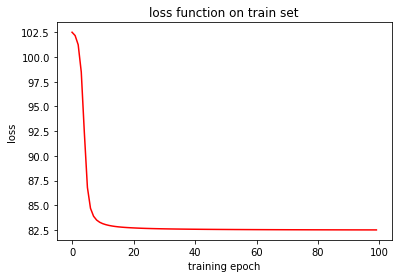

In [11]:
plt.figure(1)
ptr,=plt.plot(range(len(loss_his_train)),loss_his_train,'r-')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.title('loss function on train set')
# plt.legend((ptr),('train'))
plt.savefig('model-l.png')
plt.show()

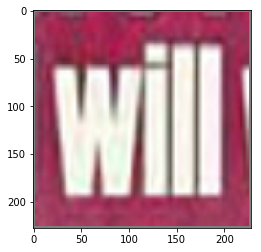

will
(1, 256, 28, 28)


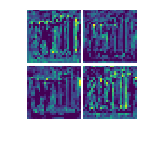

----------------------------
Variable containing:
(0 ,.,.) = 
  9.9248e-01  1.2939e-04  9.9686e-05  ...   1.1701e-04  9.7128e-05  1.1349e-04

(1 ,.,.) = 
  9.9844e-01  2.6443e-05  1.9107e-05  ...   2.2331e-05  1.8623e-05  2.2806e-05

(2 ,.,.) = 
  9.9892e-01  1.8245e-05  1.3031e-05  ...   1.5189e-05  1.2667e-05  1.5720e-05
...

(25,.,.) = 
  9.9891e-01  1.8336e-05  1.3078e-05  ...   1.5219e-05  1.2753e-05  1.5882e-05

(26,.,.) = 
  9.9840e-01  2.7087e-05  1.9343e-05  ...   2.2342e-05  1.9106e-05  2.3617e-05

(27,.,.) = 
  9.9193e-01  1.3944e-04  1.0203e-04  ...   1.1244e-04  1.0404e-04  1.2530e-04
[torch.cuda.FloatTensor of size 28x1x63 (GPU 0)]

Variable containing:
 23
  9
 12
 12
[torch.IntTensor of size 4]

81.53233337402344


In [12]:
dataiter = iter(loader_test)
image_test, label_test = dataiter.next()

imshow(utils.make_grid(image_test))
print(label_test[0])

x_var_test = Variable(image_test.type(dtype))
out=my_model.feature_extractor(x_var_test)
feature_map=out.cpu().data.numpy()
print(feature_map.shape)
sample_index=np.random.choice(256,4)
plt.figure(figsize = (2,2))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(4):
    plt.subplot(gs1[i])
    feature_submap=feature_map[0,sample_index[i],:,:]
    plt.imshow(feature_submap)
    plt.axis('off')
plt.show()

my_model.RNN.init_hidden(1)
result=my_model(x_var_test)
result_np=result.cpu().data.numpy()
result_word=''
for i in range(sequence_len):
    ch=np.argmax(result_np[i,0,:])
    result_word+=indexTochr[ch]
print(result_word)

out_size=Variable(torch.IntTensor([sequence_len]))
y_size=Variable(torch.IntTensor([len(l) for l in label_test]))
conc_label=''.join(label_test)
y=[chrToindex[c] for c in conc_label]
y_var=Variable(torch.IntTensor(y))
loss=loss_function(result,y_var,out_size,y_size)
print(result)
print(y_var)
print(loss.data[0])

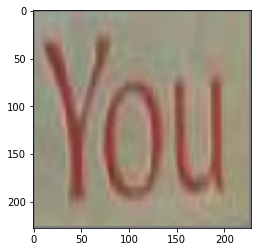

You
(1, 256, 28, 28)


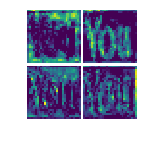

----------------------------
Variable containing:
(0 ,.,.) = 
  9.9269e-01  1.2583e-04  9.6807e-05  ...   1.1357e-04  9.4267e-05  1.1033e-04

(1 ,.,.) = 
  9.9847e-01  2.6058e-05  1.8820e-05  ...   2.1982e-05  1.8336e-05  2.2469e-05

(2 ,.,.) = 
  9.9893e-01  1.8126e-05  1.2944e-05  ...   1.5087e-05  1.2581e-05  1.5614e-05
...

(25,.,.) = 
  9.9892e-01  1.8150e-05  1.2948e-05  ...   1.5061e-05  1.2621e-05  1.5717e-05

(26,.,.) = 
  9.9845e-01  2.6317e-05  1.8799e-05  ...   2.1697e-05  1.8540e-05  2.2945e-05

(27,.,.) = 
  9.9248e-01  1.3018e-04  9.5027e-05  ...   1.0474e-04  9.6641e-05  1.1672e-04
[torch.cuda.FloatTensor of size 28x1x63 (GPU 0)]

Variable containing:
 51
 15
 21
[torch.IntTensor of size 3]

86.02954864501953


In [13]:
dataiter = iter(loader_train)
image_train, label_train = dataiter.next()
image_train=image_train[0,...].resize_([1]+list(image_train.size())[1:])

imshow(utils.make_grid(image_train))
print(label_train[0])

x_var_train = Variable(image_train.type(dtype))
out=my_model.feature_extractor(x_var_train)
feature_map=out.cpu().data.numpy()
print(feature_map.shape)
sample_index=np.random.choice(256,4)
plt.figure(figsize = (2,2))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(4):
    plt.subplot(gs1[i])
    feature_submap=feature_map[0,sample_index[i],:,:]
    plt.imshow(feature_submap)
    plt.axis('off')
plt.show()

my_model.RNN.init_hidden(1)
result=my_model(x_var_train)
result_np=result.cpu().data.numpy()
result_word=''
for i in range(sequence_len):
    ch=np.argmax(result_np[i,0,:])
    result_word+=indexTochr[ch]
print(result_word)

out_size=Variable(torch.IntTensor([sequence_len]))
y_size=Variable(torch.IntTensor([len(l) for l in label_train[0]]))
conc_label=''.join(label_train[0])
y=[chrToindex[c] for c in conc_label]
y_var=Variable(torch.IntTensor(y))
loss=loss_function(result,y_var,out_size,y_size)
print(result)
print(y_var)
print(loss.data[0])